# Looking for Autapses in the 1mm$^3$ Allen dataset

In [48]:
import os
import matplotlib.pyplot as plt
import numpy as np

# packages from Allen Institute:
from meshparty import meshwork # version 1.16.4
import pcg_skel # version 0.3.0 
from caveclient import CAVEclient # version 4.16.2

In [49]:
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)
client.materialize.version = 343

In [50]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

## Get annotated Basket cells

In [45]:
list_of_BCs = client.materialize.query_table('allen_v1_column_types_slanted',
                                             filter_equal_dict={'cell_type':'BC'})

In [63]:
print('Number of identified Basket cells :', len(list_of_BCs))
list_of_BCs[::12]

Number of identified Basket cells : 59


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,360,t,aibs_coarse_inhibitory,BC,88189698098499323,864691135748826153,"[170352, 192608, 20580]"
12,928,t,aibs_coarse_inhibitory,BC,88395925248322467,864691135946995809,"[171712, 156048, 20707]"
24,1255,t,aibs_coarse_inhibitory,BC,90588695232730561,864691135446864980,"[187824, 240512, 22174]"
36,1305,t,aibs_coarse_inhibitory,BC,90791348969779331,864691135785708484,"[189456, 177392, 22310]"
48,2031,t,aibs_coarse_inhibitory,BC,91218852700367385,864691135194776874,"[192384, 216944, 21284]"


## Loop over BC synapses to find autapses

In [165]:
print('============ Table of synapses / autapses for all BC cells')

Fraction_Autapses, Nsynapses = [], []
for pt_root_id in list_of_BCs.pt_root_id:
    # the table of synapses that with the BC ID as a post-synaptic identity
    synapse_table = client.materialize.query_table('synapses_pni_2',
                                                   filter_equal_dict={'post_pt_root_id':pt_root_id})
    # autapse: pre=post
    autapses = np.sum(np.array(synapse_table.pre_pt_root_id)==pt_root_id)
    Nsynapses.append(len(synapse_table))
    Fraction_Autapses.append(1e2*autapses/Nsynapses[-1])
    
    print('- BC-ID: %i,     N_synapses=%i,     N_autapses=%i,   fraction=%.2f%% ' % (pt_root_id,
                                                                               Nsynapses[-1], autapses, 
                                                                               Fraction_Autapses[-1]))


============ Table of synapses / autapses for all BC cells
- BC-ID: 864691135748826153,     N_synapses=4505,     N_autapses=23,   fraction=0.51% 
- BC-ID: 864691135490941927,     N_synapses=9518,     N_autapses=36,   fraction=0.38% 
- BC-ID: 864691135462578333,     N_synapses=6840,     N_autapses=31,   fraction=0.45% 
- BC-ID: 864691135367305465,     N_synapses=6984,     N_autapses=44,   fraction=0.63% 
- BC-ID: 864691135385703509,     N_synapses=6513,     N_autapses=28,   fraction=0.43% 
- BC-ID: 864691135807647773,     N_synapses=8222,     N_autapses=39,   fraction=0.47% 
- BC-ID: 864691135490498663,     N_synapses=9022,     N_autapses=22,   fraction=0.24% 
- BC-ID: 864691135939961766,     N_synapses=9047,     N_autapses=42,   fraction=0.46% 
- BC-ID: 864691135502190941,     N_synapses=9414,     N_autapses=24,   fraction=0.25% 
- BC-ID: 864691135472343346,     N_synapses=7562,     N_autapses=17,   fraction=0.22% 
- BC-ID: 864691135684442807,     N_synapses=12597,     N_autapses=75,  

[]

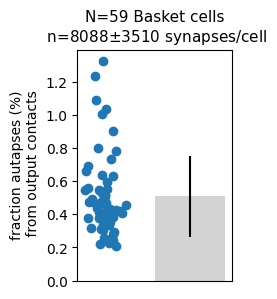

In [166]:
fig, ax = plt.subplots(1, figsize=(2,3))
ax.scatter(.1*np.random.randn(len(Nsynapses)), Fraction_Autapses)
ax.bar([1], [np.mean(Fraction_Autapses)], yerr=[np.std(Fraction_Autapses)], color='lightgrey')
ax.set_ylabel('fraction autapses (%)\n from output contacts')
ax.set_title('N=%i Basket cells\n n=%.0f$\pm$%.0f synapses/cell' % (len(Nsynapses),
                                                                   np.mean(Nsynapses), np.std(Nsynapses)),
            fontsize=11)
ax.set_xticks([])

## Visualizing a few Basket cells with their autapses

In [168]:
# from the Allen database, we focus on the downloaded "Basket" cells:
cells = {'Basket': [os.path.join('..', 'data', fn) for fn in os.listdir('../data') if 'BC' in fn]}

In [169]:
def load_cell(nrn_h5_file):
    """
    we translate everything in terms of skeleton indices ! (mesh properties)
    """
    nrn = meshwork.load_meshwork(nrn_h5_file)
    
    nrn.pre_syn_sites = nrn.skeleton.mesh_to_skel_map[nrn.anno.pre_syn.df['pre_pt_mesh_ind']]
    
    nrn.post_syn_sites = nrn.skeleton.mesh_to_skel_map[nrn.anno.post_syn.df['post_pt_mesh_ind']]
    
    nrn.root_id = int(nrn_h5_file.split('-')[-1].replace('.h5', ''))
    nrn.pre_pt_root_id = nrn.anno.post_syn.df['pre_pt_root_id']
    
    axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(nrn, 
                                                                pre_anno='pre_syn',
                                                                post_anno='post_syn')
    
    if Q>0.5:
        nrn.axon_inds = nrn.skeleton.mesh_to_skel_map[axon_inds]
        nrn.is_axon = np.array([(m in nrn.axon_inds) for m in nrn.skeleton_indices], dtype=bool)
        # dendritic cover paths
        nrn.dend_cover_paths = []
        for cover_path in nrn.skeleton.cover_paths:
            path = [c for c in cover_path if c not in nrn.axon_inds]
            if len(path)>0:
                nrn.dend_cover_paths.append(path)
    else:
        print('axon splitting not trusted...')

    # find autapses --- synapses where pre-ID=post-ID=root-ID
    nrn.autapses = client.materialize.query_table('synapses_pni_2',
                                                   filter_equal_dict={'pre_pt_root_id':nrn.root_id,
                                                                      'post_pt_root_id':nrn.root_id})
    

    return nrn

def plot_cell(nrn, 
              ax=None, 
              shift=0,
              proj_axis1=0, proj_axis2=1, 
              with_pre = False,
              with_post = False,
              with_autapses = True,
              with_segID=True,
              color='k', dend_color='r',
              clean=True, lw=0.2):
    
    if ax is None:
        ax = plt.gca()

    # plotting using the "cover_paths"
    for cover_path in nrn.skeleton.cover_paths:
        path_verts = nrn.skeleton.vertices[cover_path,:]
        ax.plot(shift+\
                path_verts[:,proj_axis1]/1e3, 
                path_verts[:,proj_axis2]/1e3,
                color=color, lw=lw)
        
    for cover_path in nrn.dend_cover_paths:
        path_verts = nrn.skeleton.vertices[cover_path,:]
        ax.plot(shift+\
                path_verts[:,proj_axis1]/1e3, 
                path_verts[:,proj_axis2]/1e3,
                color=dend_color, lw=3*lw)
        
    if with_pre:
        ax.scatter(shift+\
                   nrn.anno.pre_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.pre_syn.points[:,proj_axis2]/1e3,
                   color='tomato', s=8, alpha=.5, label='pre syn.')

    if with_post:
        ax.scatter(shift+\
                   nrn.anno.post_syn.points[:,proj_axis1]/1e3,
                   nrn.anno.post_syn.points[:,proj_axis2]/1e3,
                   color='turquoise', s=8, alpha=.5, label='post syn.')
    
    if with_autapses:
        for pre_pt in nrn.autapses.pre_pt_position:
            ax.scatter(shift+4e-3*pre_pt[proj_axis1],
                       4e-3*pre_pt[proj_axis2],
                       color='blue', s=12, alpha=.5, label='post syn.')

    ax.set_title('BC-ID: %s, %i synapses, %i autapses' % (nrn.seg_id,
                                                          len(nrn.anno.pre_syn),
                                                          len(nrn.autapses)), fontsize=10)
    ax.annotate('autapses \n\n\n\n', (1, 0), xycoords='axes fraction', fontsize=11, ha='right', color='blue')
    ax.annotate('dendrites \n\n', (1, 0), xycoords='axes fraction', fontsize=8, ha='right', color='r')
    ax.annotate('axon \n', (1, 0), xycoords='axes fraction', fontsize=8, ha='right')
    ax.set_ylabel('um')
    ax.set_xlabel('um')


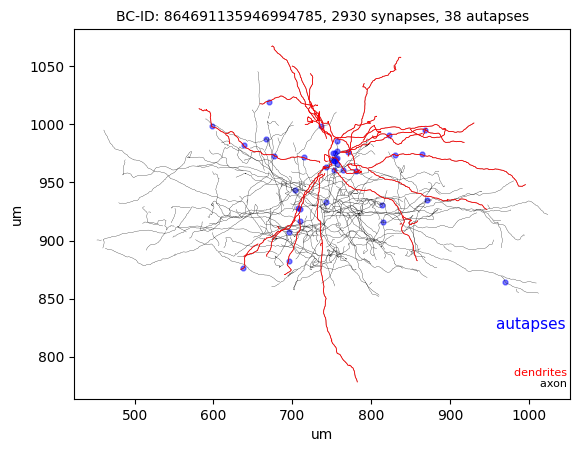

In [179]:
plot_cell(load_cell(cells['Basket'][6]))

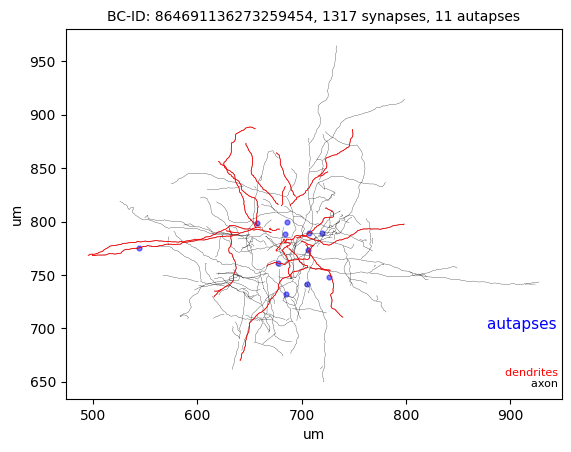

In [173]:
plot_cell(load_cell(cells['Basket'][0]))

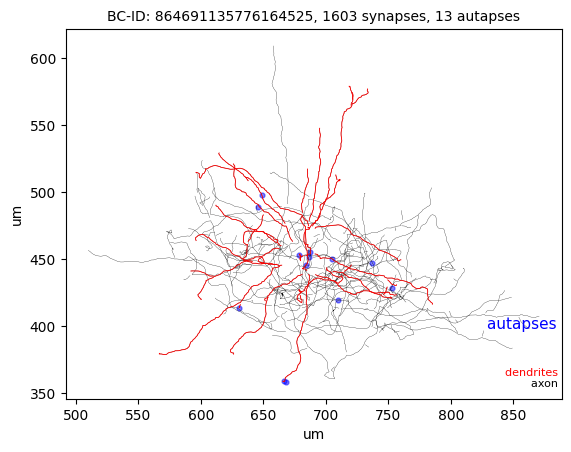

In [174]:
plot_cell(load_cell(cells['Basket'][1]))

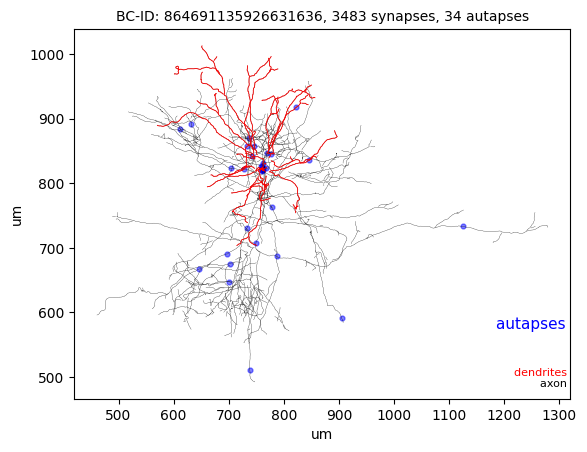

In [175]:
plot_cell(load_cell(cells['Basket'][2]))

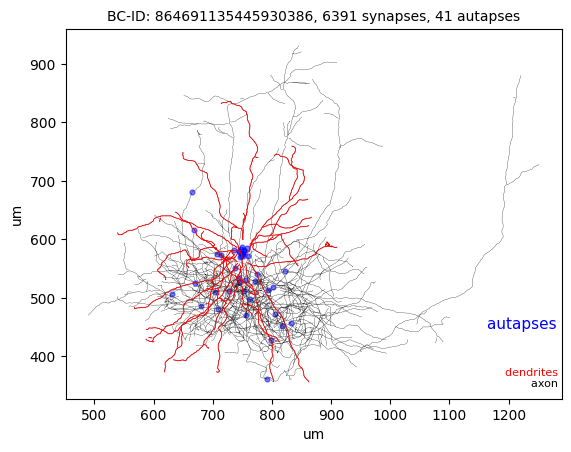

In [176]:
plot_cell(load_cell(cells['Basket'][3]))

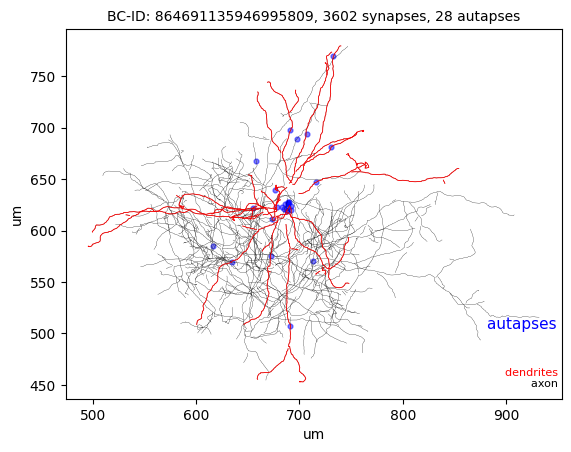

In [177]:
plot_cell(load_cell(cells['Basket'][5]))